<a href="https://colab.research.google.com/github/Monique14041980/dtat-brent-price/blob/main/Modulo04v04_ipea.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install seaborn
%pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


#xgboost

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
import matplotlib.pyplot as plt

In [3]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime

# URL do site IPEADATA
url = 'http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view'

# Faz uma requisição GET ao site e captura a resposta
response = requests.get(url)

# Verifica se a requisição foi bem sucedida
if response.status_code == 200:
    # Cria um objeto BeautifulSoup para analisar o HTML
    soup = BeautifulSoup(response.text, 'html.parser')

    # Procura pela tabela no HTML analisado (o id ou classe pode variar)
    # Você precisaria inspecionar o HTML para obter o seletor correto
    table = soup.find('table', {'id': 'grd_DXMainTable'})

    # Usa o pandas para ler a tabela HTML diretamente para um DataFrame
    df = pd.read_html(str(table),skiprows=0)[0]

    df.columns = df.iloc[0]
    df = df.drop(0)

    # Mostra as primeiras linhas do DataFrame
    df.head()
else:
    print('Falha ao acessar a página: Status Code', response.status_code)


/tmp/ipykernel_87005/2507319983.py:22: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table),skiprows=0)[0]


In [4]:
df.head()

,Data,Preço - petróleo bruto - Brent (FOB)
1,13/05/2024,8318
2,10/05/2024,8339
3,09/05/2024,8327
4,08/05/2024,8244
5,07/05/2024,8269


#update com request

In [12]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime


# Função para atualizar o DataFrame com novos dados
def update_dataframe(df, new_data):

    # Converte a coluna 'Data' para datetime
    df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)
    new_data['Data'] = pd.to_datetime(new_data['Data'], dayfirst=True)


    # Encontra a data mais recente no DataFrame existente
    last_date = df['Data'].max()

    # Filtra as novas linhas que são mais recentes do que a última data
    new_rows = new_data[new_data['Data'] > last_date]

    # Concatena os novos dados com o DataFrame existente se houver novas linhas
    if not new_rows.empty:
        updated_df = pd.concat([df, new_rows], ignore_index=True)
    else:
        updated_df = df

    return updated_df

# URL do site IPEADATA
url = 'http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view'

# Faz uma requisição GET ao site e captura a resposta
response = requests.get(url)

# Verifica se a requisição foi bem sucedida
if response.status_code == 200:
    # Cria um objeto BeautifulSoup para analisar o HTML
    soup = BeautifulSoup(response.text, 'html.parser')
    # Procura pela tabela no HTML analisado
    table = soup.find('table', {'id': 'grd_DXMainTable'})
    # Usa o pandas para ler a tabela HTML diretamente para um DataFrame
    new_df = pd.read_html(str(table), header=0)[0]

    # Verifica se o arquivo do DataFrame existe e carrega, ou cria um novo DataFrame se não existir
    path = '/workspaces/dtat-brent-price/ipea.csv'
    try:
        existing_df = pd.read_csv ('/workspaces/dtat-brent-price/ipea.csv', delimiter=';')
        
    except FileNotFoundError:
        existing_df = new_df  # Se o arquivo não existir, considere os dados atuais como o DataFrame existente

    # Atualiza o DataFrame existente com novos dados (carga incremental)
    updated_df = update_dataframe(existing_df, new_df)

    updated_df['Preço - petróleo bruto - Brent (FOB)'] = updated_df['Preço - petróleo bruto - Brent (FOB)']/100

    # Salva o DataFrame atualizado para o arquivo
    updated_df.to_csv(path, index=False)

    # Mostra as primeiras linhas do DataFrame atualizado
    updated_df.head()
else:
    print('Falha ao acessar a página: Status Code', response.status_code)

/tmp/ipykernel_87005/3511219541.py:42: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  new_df = pd.read_html(str(table), header=0)[0]


In [13]:
print(df.columns)


Index(['Data', 'Preço - petróleo bruto - Brent (FOB)'], dtype='object', name=0)


In [14]:
updated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11169 entries, 0 to 11168
Data columns (total 2 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Data                                  11169 non-null  datetime64[ns]
 1   Preço - petróleo bruto - Brent (FOB)  11169 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 174.6 KB


#Xgboost

In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator


# Carregar o DataFrame
df = pd.read_csv('/workspaces/dtat-brent-price/dtat_price/ipea.csv', delimiter=';')
df['Data'] = pd.to_datetime(df['Data'])
df = df.sort_values(by='Data', ascending=True).reset_index(drop=True)
df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)
df['Preço - petróleo bruto - Brent (FOB)'] = df['Preço - petróleo bruto - Brent (FOB)'].str.replace(',', '.').astype(float)

# Certifique-se de que os preços são float

# É uma boa prática criar recursos de atraso (lag features) para séries temporais
# Vamos criar alguns para nosso modelo
# Criar recursos de atraso (lag features)
lags = 7
for lag in range(1, lags + 1):
    df[f'Preço_lag_{lag}'] = df['Preço - petróleo bruto - Brent (FOB)'].shift(lag)

# Removemos quaisquer linhas com valores NaN que foram criados ao fazer o shift
df = df.dropna()

# Preparando os dados para treinamento
X = df[['Preço_lag_1']].values  # Inputs são os preços atrasados
y = df['Preço - petróleo bruto - Brent (FOB)'].values  # Output é o preço atual

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# modelo XGBoost com ajustes nos parâmetros
modelo = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=300,  # número de estimadores
    learning_rate=0.05,  # Ajuste a taxa de aprendizado
    max_depth=6,  # Ajuste a profundidade máxima da árvore
)
modelo.fit(X_train, y_train)


/tmp/ipykernel_601/451422005.py:15: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Data'] = pd.to_datetime(df['Data'])


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [6]:
print(df.columns)


Index(['Data', 'Preço - petróleo bruto - Brent (FOB)', 'Preço_lag_1',
       'Preço_lag_2', 'Preço_lag_3', 'Preço_lag_4', 'Preço_lag_5',
       'Preço_lag_6', 'Preço_lag_7'],
      dtype='object')


In [7]:
print(df['Data'].unique())


<DatetimeArray>
['1987-05-29 00:00:00', '1987-06-01 00:00:00', '1987-06-02 00:00:00',
 '1987-06-03 00:00:00', '1987-06-04 00:00:00', '1987-06-05 00:00:00',
 '1987-06-08 00:00:00', '1987-06-09 00:00:00', '1987-06-10 00:00:00',
 '1987-06-11 00:00:00',
 ...
 '2024-01-03 00:00:00', '2024-01-04 00:00:00', '2024-01-05 00:00:00',
 '2024-01-08 00:00:00', '2024-01-09 00:00:00', '2024-01-10 00:00:00',
 '2024-01-11 00:00:00', '2024-01-12 00:00:00', '2024-01-15 00:00:00',
 '2024-01-16 00:00:00']
Length: 11081, dtype: datetime64[ns]


Mean Squared Error: 2.8686710673035036
Mean Absolute Error: 1.1935082148042835


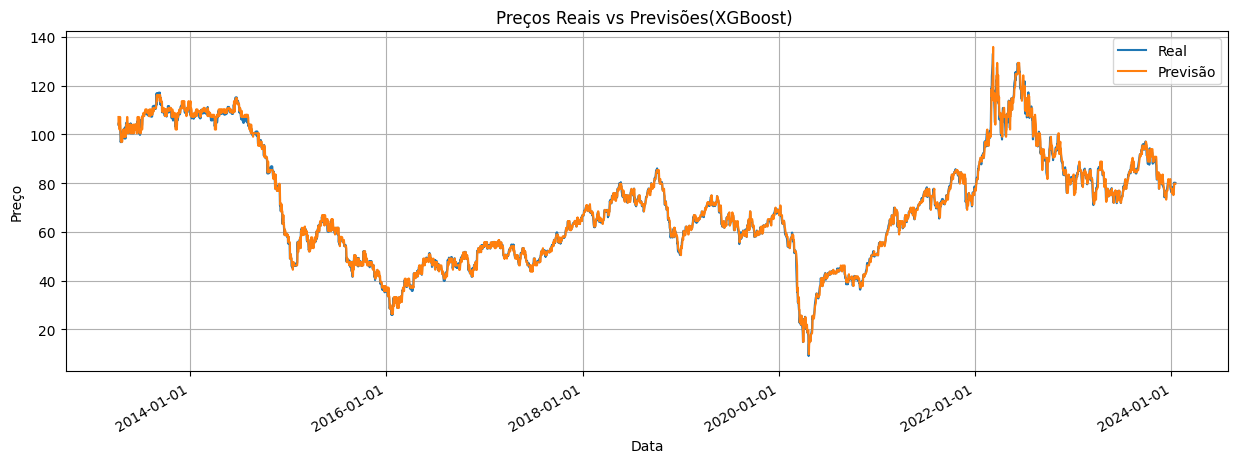

In [8]:
# Fazer previsões
predictions = modelo.predict(X_test)

# Avaliar o modelo
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

# Opcional: Plotando resultados reais vs previstos. Tem que ter matplotlib instalado.
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(15, 5))
plt.plot(df['Data'].iloc[-len(y_test):], y_test, label='Real')
plt.plot(df['Data'].iloc[-len(predictions):], predictions, label='Previsão')
# Melhorar a formatação do eixo x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Formatar as datas como 'Ano-Mês-Dia'
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())             # Escolher automaticamente a localização das datas
# Melhorar a legibilidade girando as datas e ajustando o espaçamento
plt.gcf().autofmt_xdate()  # Gira as datas para evitar sobreposição
plt.legend()
plt.xlabel('Data')
plt.ylabel('Preço')
plt.grid(True)
plt.title('Preços Reais vs Previsões(XGBoost) ')
plt.show()

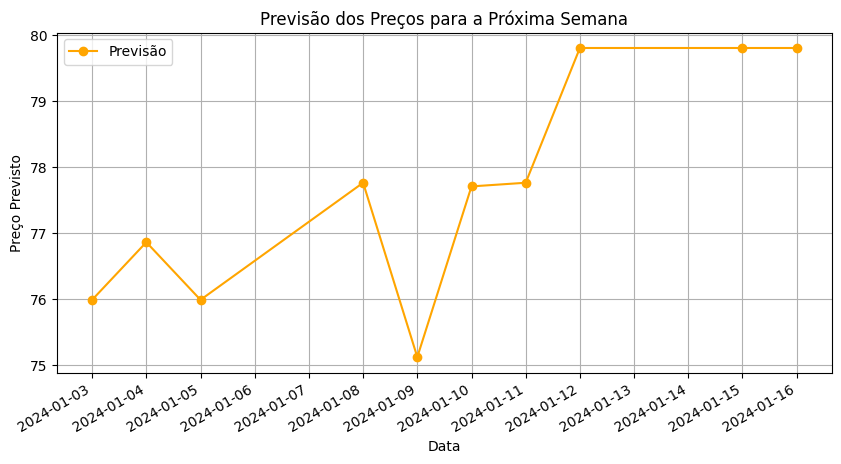

In [9]:
predictions_next_week = predictions[-10:]  # Ajustar o número conforme necessário
df_next_week_dates = df['Data'].iloc[-len(y_test):][-10:]  # Ajustar o número conforme necessário

# Plotar os resultados
plt.figure(figsize=(10, 5))
# Certifique-se de reverter os dados para que as datas sejam plotadas em ordem cronológica
plt.plot(df_next_week_dates[::-1], predictions_next_week[::-1], label='Previsão', color='orange', marker='o')

# Formatar o eixo x para apresentar as datas
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gcf().autofmt_xdate()  # Auto formatar as datas para evitar sobreposição

plt.title('Previsão dos Preços para a Próxima Semana')
plt.xlabel('Data')
plt.ylabel('Preço Previsto')
plt.legend()
plt.grid(True)
plt.show()


In [45]:
len(predictions)

3325

In [107]:
X_train

array([[ 18.75,  18.65],
       [ 18.78,  18.75],
       [ 18.78,  18.78],
       ...,
       [107.82, 109.66],
       [105.09, 107.82],
       [103.98, 105.09]])

In [108]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# importar as bibliotecas
import warnings
warnings.filterwarnings('ignore')


# GradienteBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd


import pickle
import joblib

In [115]:
%pip install yfinance

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [116]:
#fonte dos índices e cotações:   https://finance.yahoo.com/
indice = "BZ=F"   # Brent Crude Oil Last Day Financ (BZ=F)
inicio = "2007-07-30" #Define a data de ínicio para importação dos dados
#Coleta dados históricos do índice de referência até a data corrente
dados_acao = yf.download(indice, inicio)
#Quando a biblioteca é chamada sem uma data final, carrega as cotações até a data corrente
df_cotacoes =pd.DataFrame(dados_acao)

[*********************100%%**********************]  1 of 1 completed


In [123]:
dados = df_cotacoes.copy()

In [135]:
dados_site = pd.read_html('http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view[2]')

dados_url = dados_site[2]

dados = dados.reset_index()

dados_url.columns = ['Data','Preco_Petroleo_Brent_FOB']

dados_url.set_index('Data')

dados_url = dados_url.iloc[1:]

dados_url.fillna(method='ffill', inplace=True)

dados_url['Preco_Petroleo_Brent_FOB'] = dados_url['Preco_Petroleo_Brent_FOB'].astype('float')/100

dados_url['Data'] = pd.to_datetime(dados_url['Data'], dayfirst=True)

dados_url = dados_url.set_index('Data').sort_index(ascending=True)

dados_url = dados_url.reset_index()

In [133]:
dados_url.to_csv('ipea_url.csv', index=False)

In [134]:


# É uma boa prática criar recursos de atraso (lag features) para séries temporais
# Vamos criar alguns para nosso modelo
# Criar recursos de atraso (lag features)
lags = 7
for lag in range(1, lags + 1):
    df[f'Preço_lag_{lag}'] = df['Preço - petróleo bruto - Brent (FOB)'].shift(lag)

# Removemos quaisquer linhas com valores NaN que foram criados ao fazer o shift
df = df.dropna()

# Preparando os dados para treinamento
X = df[['Preço_lag_1', 'Preço_lag_2']].values  # Inputs são os preços atrasados
y = df['Preço - petróleo bruto - Brent (FOB)'].values  # Output é o preço atual

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

from sklearn.ensemble import RandomForestRegressor
# Criar e treinar o modelo Random Forest
model_rf = RandomForestRegressor(n_estimators=300, random_state=42)
model_rf.fit(X_train, y_train)




KeyError: 'Preço - petróleo bruto - Brent (FOB)'

#RandomForest

In [136]:
# Fazer previsões
predictions = model_rf.predict(X_test)

# Avaliar o modelo
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

In [137]:
print(f'MSE: {mse:.2f}')
print(f'MAE: {mae:.2f}')

MSE: 3.48
MAE: 1.35


2024-01-17 00:00:00: 79.34
2024-01-18 00:00:00: 79.64
2024-01-19 00:00:00: 79.75
2024-01-20 00:00:00: 80.03
2024-01-21 00:00:00: 78.70
2024-01-22 00:00:00: 78.09
2024-01-23 00:00:00: 78.33


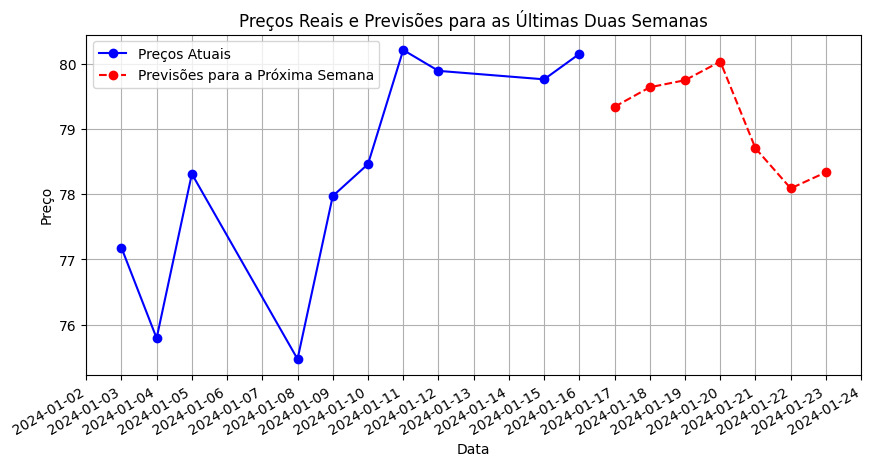

In [120]:
# Fazer previsões para a próxima semana usando os últimos dados conhecidos
last_known_data = X[-1].reshape(1, -1)
next_week_predictions = []
for _ in range(7):  # para cada dia da próxima semana
    next_day_pred = model_rf.predict(last_known_data)[0]
    next_week_predictions.append(next_day_pred)
    last_known_data = np.roll(last_known_data, -1)
    last_known_data[0, -1] = next_day_pred

# As datas correspondentes à próxima semana
next_week_dates = pd.date_range(df['Data'].iloc[-1], periods=8)[1:]

# Selecionar os dados da semana atual (últimos 7 dias do dataset)
current_week_dates = df['Data'].iloc[-10:]
current_week_prices = df['Preço - petróleo bruto - Brent (FOB)'].iloc[-10:]

for week, pred in zip(next_week_dates, next_week_predictions):
    print(f'{week}: {pred:.2f}')

# Plotar os preços reais da semana atual e as previsões para a próxima semana
plt.figure(figsize=(10, 5))
plt.plot(current_week_dates, current_week_prices, 'bo-', label='Preços Atuais')
plt.plot(next_week_dates, next_week_predictions, 'r--o', label='Previsões para a Próxima Semana')

# Formatar o eixo x para exibir datas
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gcf().autofmt_xdate()  # Ajustar formato das datas para evitar sobreposição

plt.xlabel('Data')
plt.ylabel('Preço')
plt.title('Preços Reais e Previsões para as Últimas Duas Semanas')
plt.legend()
plt.grid(True)
plt.show()

In [60]:
%pip install yfinance

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 33.3 MB/s eta 0:00:00:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.0/73.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 2.9 MB/s eta 0:00:00ta 0:00:01
  Created wheel for peewee: filename=peewee-3.17.5-cp311-cp311-linux_x86_64.whl size=894048 sha256=afb5c30194717223aab582c15a800f95f68932450e84eac0d6e8c5ea6364fc56
  Stored in directory: /home/vscode/.cache/pip/wheels/d2/cb/9c/c300d7bf782e07f1658c306743d5e30af7e4834001e4064a96
Successfully built peewee
Note: you may need to restart the kernel to use updated packages.


In [62]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# importar as bibliotecas
import warnings
warnings.filterwarnings('ignore')


# GradienteBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd


import pickle
import joblib

In [64]:
#fonte dos índices e cotações:   https://finance.yahoo.com/
indice = "BZ=F"   # Brent Crude Oil Last Day Financ (BZ=F)
inicio = "2007-07-30" #Define a data de ínicio para importação dos dados
#Coleta dados históricos do índice de referência até a data corrente
dados_acao = yf.download(indice, inicio)
#Quando a biblioteca é chamada sem uma data final, carrega as cotações até a data corrente
df_cotacoes =pd.DataFrame(dados_acao)

[*********************100%%**********************]  1 of 1 completed


In [121]:
dados = df_cotacoes.copy()

In [122]:
dados.shape

(4171, 6)

In [67]:
dados.drop('Adj Close', axis=1, inplace=True)
dados.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4171 entries, 2007-07-30 to 2024-05-16
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    4171 non-null   float64
 1   High    4171 non-null   float64
 2   Low     4171 non-null   float64
 3   Close   4171 non-null   float64
 4   Volume  4171 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 195.5 KB


In [68]:
dados = dados.reset_index()
dados.isnull().sum()
dados.dtypes

Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume             int64
dtype: object

In [69]:
dados.describe()

,Date,Open,High,Low,Close,Volume
count,4171,4171.000000,4171.000000,4171.000000,4171.000000,4171.000000
mean,2016-01-11 03:23:00.100695040,78.693985,79.658087,77.675195,78.696675,17482.363942
min,2007-07-30 00:00:00,19.559999,21.270000,16.000000,19.330000,0.000000
25%,2011-11-01 12:00:00,59.070000,60.025000,58.215000,59.005001,1127.000000
50%,2016-01-26 00:00:00,76.730003,77.629997,75.669998,76.839996,16576.000000
75%,2020-03-23 12:00:00,101.760002,102.974998,100.375000,101.744999,30044.500000
max,2024-05-16 00:00:00,146.080002,147.429993,144.270004,146.080002,87185.000000
std,NaN,24.751124,24.869822,24.620904,24.769447,16184.808064


In [70]:
dados_site = pd.read_html('http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view[2]')

dados_url = dados_site[2]

#dados = dados.reset_index()

dados_url.columns = ['Data','Preco_Petroleo_Brent_FOB']

dados_url.set_index('Data')

dados_url = dados_url.iloc[1:]

dados_url.fillna(method='ffill', inplace=True)

dados_url['Preco_Petroleo_Brent_FOB'] = dados_url['Preco_Petroleo_Brent_FOB'].astype('float')/100

dados_url['Data'] = pd.to_datetime(dados_url['Data'], dayfirst=True)

dados_url = dados_url.set_index('Data').sort_index(ascending=True)

dados_url = dados_url.reset_index()

In [71]:
dados_url.to_csv('ipea_url.csv', index=False)

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

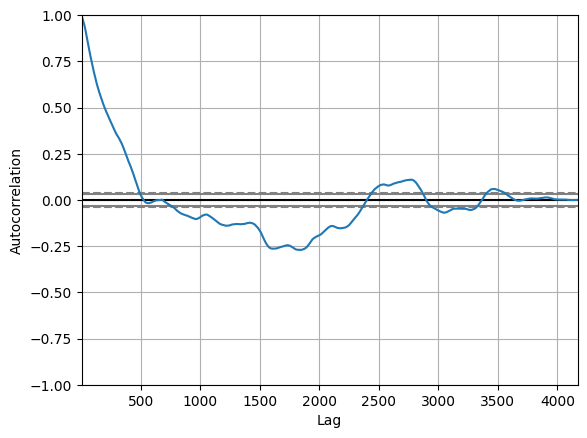

In [72]:
autocorrelation_plot(dados['Close'])

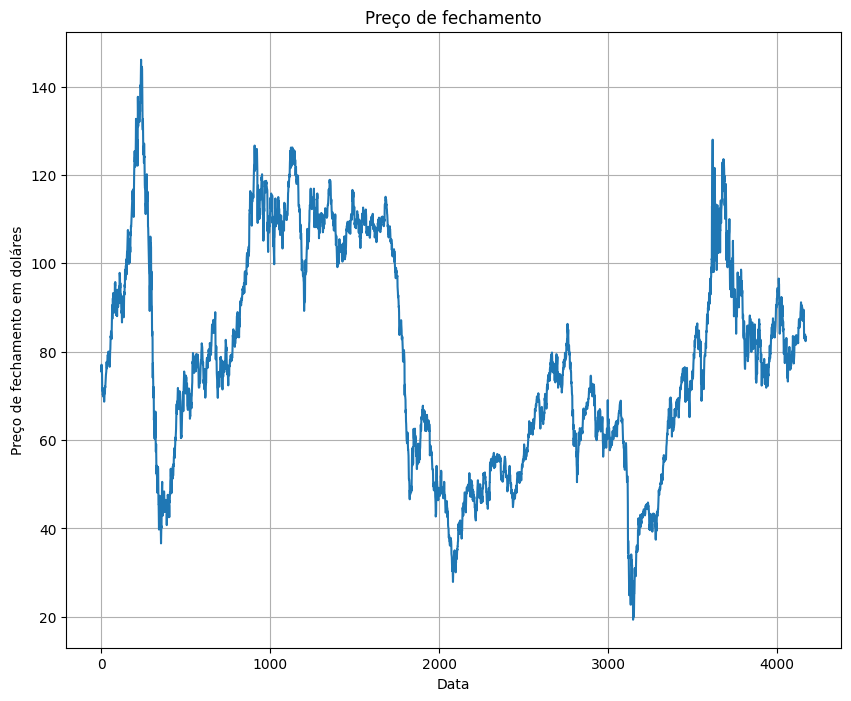

In [73]:
dados['Close'].plot( title='Preço de fechamento', figsize=(10,8),grid=True)
plt.xlabel("Data")
plt.ylabel("Preço de fechamento em doláres")

plt.show()

In [74]:
df_gb = dados_url[['Data','Preco_Petroleo_Brent_FOB']].copy()
selecao = (df_gb['Data'] >= '2000-01-01')
df_gb = df_gb[selecao]
df_gb = df_gb.set_index('Data')
df_gb = df_gb.sort_index(ascending=True)
df_gb = df_gb.reset_index()
df_gb.tail()

,Data,Preco_Petroleo_Brent_FOB
7964,2024-05-07,82.69
7965,2024-05-08,82.44
7966,2024-05-09,83.27
7967,2024-05-10,83.39
7968,2024-05-13,83.18


In [75]:
df_gb['ano'] = df_gb['Data'].dt.year
df_gb['mes'] = df_gb['Data'].dt.month

In [76]:
for lag in range(1, 3):  # Criou atraso de 1 dia nesse lag
    df_gb[f'Preco_lag_{lag}'] = df_gb['Preco_Petroleo_Brent_FOB'].shift(lag)

In [77]:
df_gb = df_gb.dropna()

In [78]:
df_gb.dtypes

Data                        datetime64[ns]
Preco_Petroleo_Brent_FOB           float64
ano                                  int32
mes                                  int32
Preco_lag_1                        float64
Preco_lag_2                        float64
dtype: object

In [79]:
df_gb[['Data','Preco_Petroleo_Brent_FOB', 'ano','mes']].to_csv('agrupado.csv', index=False)

In [80]:
#X = df_gb.drop('y', axis=1).values
X = df_gb[['Preco_lag_1','Preco_lag_2']].values
y = df_gb['Preco_Petroleo_Brent_FOB'].values

In [81]:
# Dividir os dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False, random_state=42)

In [82]:
# Treinando o modelo
model_gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42,loss='squared_error')
model_gb.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=6, random_state=42)

In [83]:
# Fazendo previsões
y_pred = model_gb.predict(X_test)

In [84]:
# Avaliando o modelo
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("r2_score:", r2)

Mean Squared Error: 3.187936202399615
Mean Absolute Error: 1.2423240503541784
r2_score: 0.9918772224236556


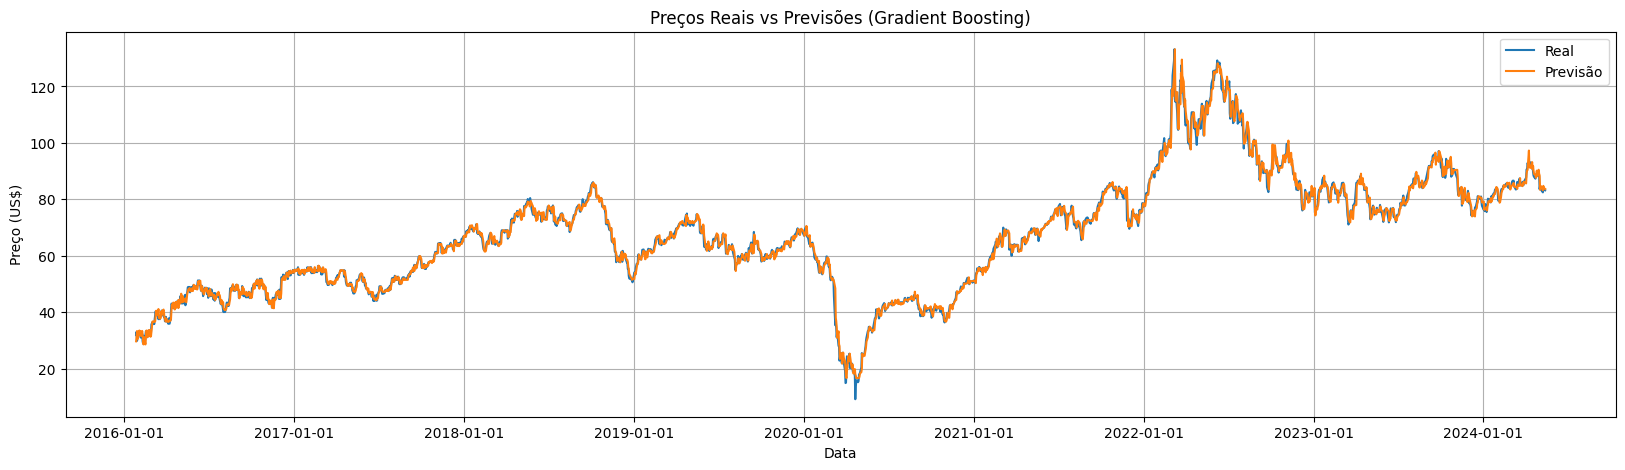

In [85]:
plt.figure(figsize=(20, 5))
plt.plot(df_gb['Data'].iloc[-len(y_test):], y_test, label='Real')
plt.plot(df_gb['Data'].iloc[-len(y_pred):], y_pred, label='Previsão')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
#plt.gcf().autofmt_xdate()
plt.legend()
plt.xlabel('Data')
plt.ylabel('Preço (US$)')
plt.grid(True)
plt.title('Preços Reais vs Previsões (Gradient Boosting)')
plt.show()

# plotando o forecasting

In [87]:
previsao_y = y_pred[-7:]
previsao_data = df_gb['Data'].iloc[-len(y_test):][-7:]

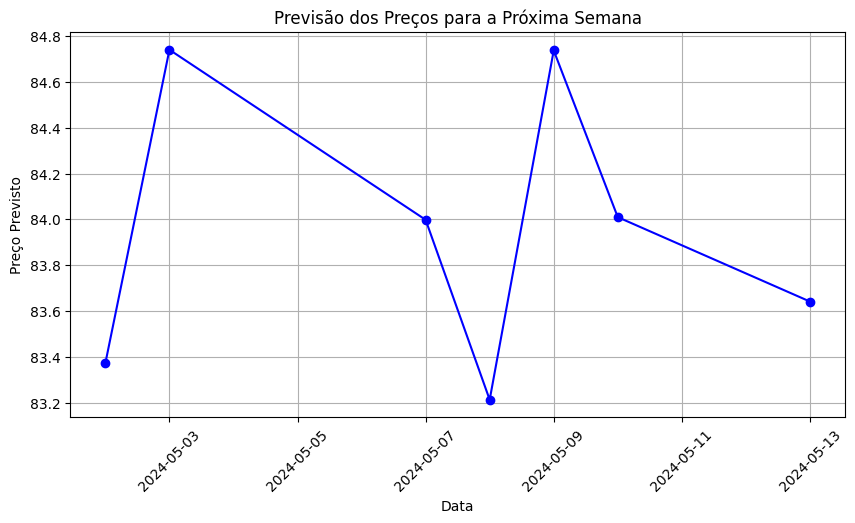

In [88]:
plt.figure(figsize=(10, 5))
plt.plot(previsao_data[::-1], previsao_y[::-1], label='Previsão', color='blue', marker='o')
plt.title('Previsão dos Preços para a Próxima Semana')
plt.xlabel('Data')
plt.ylabel('Preço Previsto')
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [89]:
param_grid={
    'n_estimators':[100,200,300],
    'learning_rate':[0.01,0.1,0.2],
    'max_depth':[3,4,5],
    'min_samples_split':[2,3,4],
    'min_samples_leaf':[1,2,3]
}

In [90]:
from sklearn.model_selection import GridSearchCV
gb_cv = GridSearchCV(model_gb, param_grid,cv=3, n_jobs=1,scoring='neg_mean_squared_error')
gb_cv.fit(X_train, y_train)
y_pred = gb_cv.predict(X_test)


In [91]:
gb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 4,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 200}

In [92]:
with open("model_gb.pkl", "wb") as file:
    pickle.dump(model_gb, file)

In [93]:
# Fazer previsões para a próxima semana usando os últimos dados conhecidos
ultima_data = X[-1].reshape(1, -1)
pred_futuro = []
for _ in range(7):  # para cada dia da próxima semana
    pred_dia_futuro = model_gb.predict(ultima_data)[0]
    pred_futuro.append(pred_dia_futuro)
    ultima_data = np.roll(ultima_data, -1)
    ultima_data[0, -1] = pred_dia_futuro


In [94]:
# As datas correspondentes à próxima semana
prox_data = pd.date_range(df_gb['Data'].iloc[-1], periods=8, freq='B')[1:]   #a frequência foi eu que coloquei, freq='B'

In [95]:
# Selecionar os dados da semana atual (últimos 7 dias do dataset)
datas_sem_atual = df_gb['Data'].iloc[-7:]
preco_sem_atual = df_gb['Preco_Petroleo_Brent_FOB'].iloc[-7:]

In [96]:
for semana, pred in zip(prox_data , pred_futuro):
    print(f'{semana}: {pred:.2f}')

2024-05-14 00:00:00: 83.64
2024-05-15 00:00:00: 83.48
2024-05-16 00:00:00: 83.68
2024-05-17 00:00:00: 83.81
2024-05-20 00:00:00: 83.50
2024-05-21 00:00:00: 83.68
2024-05-22 00:00:00: 83.81


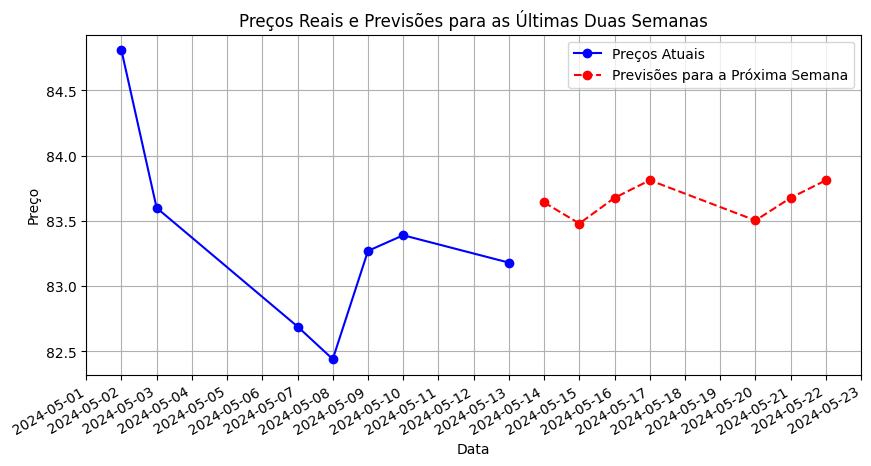

In [97]:
# Plotar os preços reais da semana atual e as previsões para a próxima semana
plt.figure(figsize=(10, 5))
plt.plot(datas_sem_atual, preco_sem_atual, 'bo-', label='Preços Atuais')
plt.plot(prox_data, pred_futuro, 'r--o', label='Previsões para a Próxima Semana')

# Formatar o eixo x para exibir datas
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gcf().autofmt_xdate()  # Ajustar formato das datas para evitar sobreposição

plt.xlabel('Data')
plt.ylabel('Preço')
plt.title('Preços Reais e Previsões para as Últimas Duas Semanas')
plt.legend()
plt.grid(True)
plt.show()